<a href="https://colab.research.google.com/github/oavrex/movies_recommendation_system/blob/main/Movie_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!unzip /content/ml-32m.zip -d /content/

Archive:  /content/ml-32m.zip
   creating: /content/ml-32m/
  inflating: /content/ml-32m/tags.csv  
  inflating: /content/ml-32m/links.csv  
  inflating: /content/ml-32m/README.txt  
  inflating: /content/ml-32m/checksums.txt  
  inflating: /content/ml-32m/ratings.csv  
  inflating: /content/ml-32m/movies.csv  


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import numpy as np


movies = pd.read_csv('/content/ml-32m/movies.csv')
ratings = pd.read_csv('/content/ml-32m/ratings.csv')


In [4]:
movies = movies.head(400)

In [5]:
ratings = ratings.head(400)

In [6]:
data = pd.merge(ratings, movies, on='movieId')

<ipython-input-36-5de7f4ed0db5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_8.index, y=top_8.values, palette='plasma')


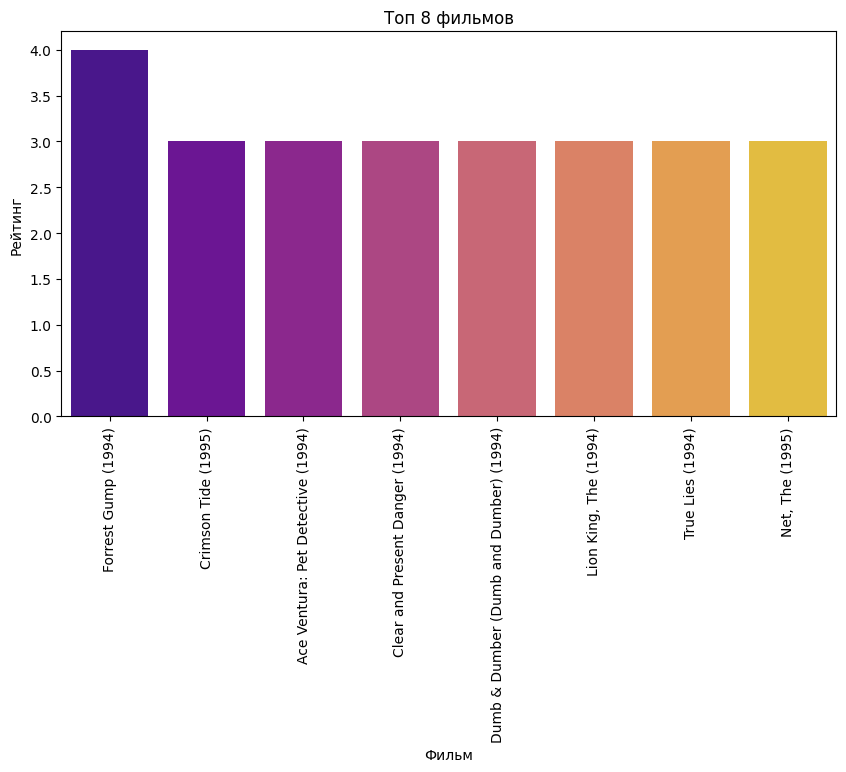

In [36]:
top_8 = data['title'].value_counts().head(8)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_8.index, y=top_8.values, palette='plasma')
plt.title('Топ 8 фильмов')
plt.xlabel('Фильм')
plt.ylabel('Рейтинг')
plt.xticks(rotation=90)
plt.show()

In [7]:
filtered_data = data.groupby('userId').filter(lambda x: len(x) >= 20)
top_titles = filtered_data['title'].value_counts().head(50).index
filtered_data = filtered_data[filtered_data['title'].isin(top_titles)]
filtered_data = filtered_data.sample(frac=0.1, random_state=1)
user_matrix = filtered_data.pivot_table(index='userId', columns='title', values='rating', fill_value=0)
user_matrix.fillna(0, inplace=True)

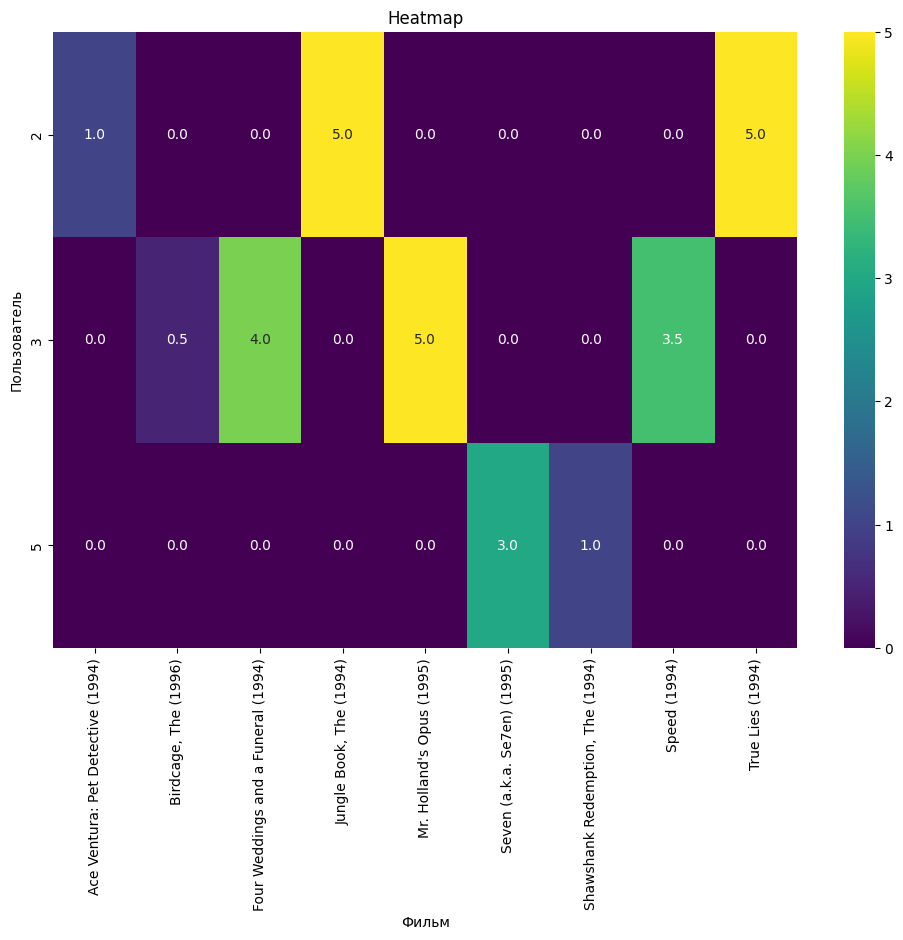

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(user_matrix.head(10).fillna(0), cmap='viridis', annot=True, fmt='.1f')
plt.title('Heatmap')
plt.xlabel('Фильм')
plt.ylabel('Пользователь')
plt.show()

In [8]:
from tqdm import tqdm
user_similarity = np.memmap('user_similarity.dat', dtype='float32', mode='w+', shape=(user_matrix.shape[0], user_matrix.shape[0]))

chunk_size = 70
for i in tqdm(range(0, user_matrix.shape[0], chunk_size), desc='Computing Similarity'):
    chunk_similarity = cosine_similarity(user_matrix.iloc[i:i + chunk_size], user_matrix)
    user_similarity[i:i + chunk_size] = chunk_similarity


user_similarity.flush()

Computing Similarity: 100%|██████████| 1/1 [00:00<00:00, 143.57it/s]


In [20]:
user_similarity = np.memmap('user_similarity.dat', dtype='float32', mode='r', shape=(user_matrix.shape[0], user_matrix.shape[0]))

user_similarity_df = pd.DataFrame(user_similarity, index=user_matrix.index, columns=user_matrix.index)

In [23]:
def predict_by_user(user_id, movie_title):
    if user_id not in user_similarity_df.index:
        return 0

    similar_users = user_similarity_df.loc[user_id]

    if movie_title not in user_matrix.columns:
        return 0

    ratings_by_similar_users = user_matrix[movie_title]


    if similar_users.sum() == 0:
        return 0

    weighted_sum = np.dot(similar_users, ratings_by_similar_users)
    predicted_rating = weighted_sum / similar_users.sum()

    return predicted_rating

In [24]:
def evaluate():
    train_data, test_data = train_test_split(data, test_size=0.2)
    test_data = test_data.reset_index(drop=True)

    predictions = []
    actuals = []

    for index, row in test_data.iterrows():
        user_id = row['userId']
        movie_title = row['title']
        actual_rating = row['rating']

        predicted_rating = predict_by_user(user_id, movie_title)
        predictions.append(predicted_rating)
        actuals.append(actual_rating)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

print(f"RMSE: {evaluate()}")

RMSE: 3.6757134770296487
